# Shopify Data Science Intern Challenge

## Goals

By the end of this challenge, I will have significantly reduced the Average Order Value from $3000+ to a few hundred dollars.

Also in this challenge, I will have been able to discuss my findings, define a metric, and explain its value.

### Preliminary EDA

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('data/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

For these next 3 code cells, I wanted to get an idea of the size of the data I was dealing with.

In [3]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [5]:
df.shape

(5000, 7)

In [6]:
df.dtypes

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object

Here, I wanted to see if there were any correlations I should pay attention to. After running the code, I saw there was statistical significance between `total_items` and `order_amount`.

In [7]:
corrm = df.corr()
corrm

,order_id,shop_id,user_id,order_amount,total_items
order_id,1.000000,-0.005967,0.002881,-0.005565,-0.006768
shop_id,-0.005967,1.000000,0.009033,-0.005559,-0.016304
user_id,0.002881,0.009033,1.000000,-0.158104,-0.161247
order_amount,-0.005565,-0.005559,-0.158104,1.000000,0.991747
total_items,-0.006768,-0.016304,-0.161247,0.991747,1.000000


Here I reaffirmed that the average order value (AOV) was in fact \\$3,145.13.  What stood out to me though was that the max `order_amount` was \\$704,000, max `total_items` was 2000, and that the standard deviation is not acceptable. So I decided to dig deeper.

In [8]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


First, I visualized with a box plot to see where `order_amount` range was.

<AxesSubplot:xlabel='order_amount'>

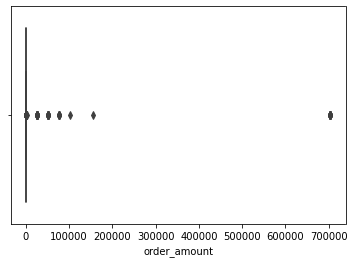

In [9]:
sns.boxplot(x=df['order_amount'])

Next, I used a scatter plot that was total items by order amount, because earlier I saw that there was a high correlation between the two. Here I noticed that the highest order amount attributed to the total items. I decided to look back at the spreadsheet further, and noticed that this repeated multiple times throughout the dataset. This was attached to the same shop id, so inferred that this may have been an aggregation of sales at that shop, or a misinput somehow. I noticed that there were also other high dollar purchases for low amounts. On further inspection in the spreadsheets, these just didn't make sense because those orders consisted of less than 5 shoes. Sneaker shoes and most designer shoes don't cost \\$51k and above. With that line of thinking, I decided those were the outliers that were affecting the AOV from earlier.

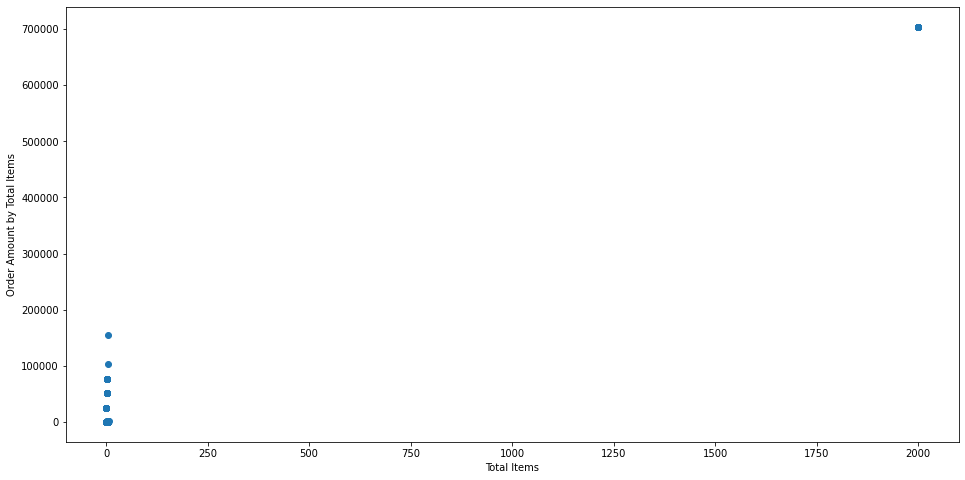

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['total_items'], df['order_amount'])
ax.set_xlabel('Total Items')
ax.set_ylabel('Order Amount by Total Items')
plt.show()

I decided to use the IQR score, because I am most familiar with box-and-whiskers plots and that was the simplest way to identify and remove outliers visually.

In [17]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

order_id        2499.5
shop_id           51.0
user_id          150.0
order_amount     227.0
total_items        2.0
dtype: float64


In [18]:
print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))

C:\Users\V\AppData\Local\Temp\ipykernel_21160\573165499.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))
C:\Users\V\AppData\Local\Temp\ipykernel_21160\573165499.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  print(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))


      created_at  order_amount  order_id  payment_method  shop_id  \
0          False         False     False           False    False   
1          False         False     False           False    False   
2          False         False     False           False    False   
3          False         False     False           False    False   
4          False         False     False           False    False   
...          ...           ...       ...             ...      ...   
4995       False         False     False           False    False   
4996       False         False     False           False    False   
4997       False         False     False           False    False   
4998       False         False     False           False    False   
4999       False         False     False           False    False   

      total_items  user_id  
0           False    False  
1           False    False  
2           False    False  
3           False    False  
4           False    False

TypeError: Cannot perform 'ror_' with a dtyped [bool] array and scalar of type [NoneType]

In [31]:
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)] #creation of cleaned dataframe
df_out.shape

C:\Users\V\AppData\Local\Temp\ipykernel_21160\4288389920.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)] #creation of cleaned dataframe


(4859, 7)

In [20]:
df_out.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,2497.395966,49.852645,849.905742,293.715374,1.950196
std,1443.356555,29.049171,86.887496,144.453395,0.919791
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1244.500000,24.000000,776.000000,162.000000,1.000000
50%,2498.000000,50.000000,850.000000,280.000000,2.000000
75%,3749.500000,74.000000,925.000000,380.000000,3.000000
max,5000.000000,100.000000,999.000000,730.000000,5.000000


# Evaulating 1.a,b,c

## A. 
The new Average Order Value is \\$293.71 is a more reasonable amount. This is because some people are buying exclusive sneaker shoes and not general releases, so this makes more sense. Lastly, each store is only selling one specific model of shoe, so the cost of the shoe in the hypothetical store is up to the owner/lister. 


## B.

I still think average order value is the overall best metric to be used for this dataset. However below, I show two other metrics that could possiblly be used and their value.

## C. 

The value is $293.71 for the new Average Order Value metric.

In [30]:
df_out['shop_id'].unique()

array([ 53,  92,  44,  18,  58,  87,  22,  64,  52,  66,  40,  54, 100,
        17,  28,  83,  63,  97,  88,  75,  73,  82,  47,  59,  76,  57,
         7,  34,  61,  84,  10,  42,   1,  21,  99,  29,  33,   3,  81,
        30,  79,  51,  80,  60,  86,  91,  72,  11,  14,   5,  20,  41,
         8,  48,  56,  55,  50,  35,  70,  77,  74,  13,  12,  68,  69,
        25,   6,  98,  24,   2,  49,  71,  16,   9,  93,  37,  26,  43,
        15,  85,  19,  27,  31,  67,  36,  39,  89,  32,  95,  38,  62,
        96,   4,  90,  94,  23,  46,  65,  45], dtype=int64)

In [29]:
df_out['order_amount'].unique()

array([224,  90, 144, 156, 138, 149, 292, 266, 146, 322, 111, 447, 176,
       164, 258, 408, 486, 704, 256, 495, 177, 145, 112, 178, 310, 294,
       465, 244, 316, 459, 148, 352, 624, 284, 195, 652, 346, 438, 296,
       399, 276, 531, 692, 181, 561, 560, 187, 260, 160, 480, 390, 184,
       122, 130, 116, 142, 127, 354, 132, 254, 584, 328, 234, 118, 513,
       193, 180, 612, 532, 320, 201, 414, 129, 136, 165, 262, 590, 374,
       153, 492, 280, 188, 312, 544, 426, 441, 290, 640, 222, 435, 173,
       306, 330, 228, 272, 489, 464, 468, 351, 147, 342, 387, 648, 488,
       362, 516, 326, 338, 117, 163, 393, 268, 588, 236, 202, 133, 336,
       585, 570, 114, 360, 512, 324, 402, 171, 128, 534, 386, 190, 131,
       420, 282, 368, 232, 432, 656, 161, 158, 519, 381, 632, 166, 543,
       356, 332, 508, 134, 392, 568, 298, 154, 172, 169, 504, 308, 712,
       520, 670, 396, 660, 579, 483, 444, 644, 462, 710, 536, 456, 380,
        94, 303, 348, 168, 507, 333, 645, 344, 376, 576, 528, 19

In [45]:
df_out.groupby('shop_id')['order_amount','total_items'].mean()

C:\Users\V\AppData\Local\Temp\ipykernel_21160\2406055101.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_out.groupby('shop_id')['order_amount','total_items'].mean()


,order_amount,total_items
shop_id,,
1,308.818182,1.954545
2,174.327273,1.854545
3,305.250000,2.062500
4,258.509804,2.019608
5,290.311111,2.044444
...,...,...
96,312.244898,2.040816
97,313.659574,1.936170
98,245.362069,1.844828


A metric that could potentially be used is the Average Order Value Per Shop. This is a more valuable metric because it adds more granularity to the data. From this metric, I can identify the shop with the highest average order amount and dive deeper into the sales.

In [49]:
df_out.groupby('shop_id')['order_amount'].mean()

shop_id
1      308.818182
2      174.327273
3      305.250000
4      258.509804
5      290.311111
          ...    
96     312.244898
97     313.659574
98     245.362069
99     322.500000
100    213.675000
Name: order_amount, Length: 99, dtype: float64

In [50]:
df_out.groupby('shop_id')['order_amount'].mean().unique()

array([308.81818182, 174.32727273, 305.25      , 258.50980392,
       290.31111111, 342.83333333, 218.        , 241.04347826,
       234.        , 324.46153846, 309.45454545, 335.        ,
       335.48387097, 242.        , 300.        , 257.4       ,
       332.0754717 , 315.25      , 313.06349206, 251.55769231,
       308.69565217, 273.75      , 309.11111111, 320.72727273,
       232.91666667, 318.29787234, 325.24528302, 320.37209302,
       323.14035088, 295.07142857, 268.9787234 , 189.97619048,
       363.74358974, 234.24      , 328.        , 254.8       ,
       340.20833333, 343.22580645, 268.        , 295.16666667,
       254.        , 515.42857143, 320.71929825, 262.15384615,
       269.31034483, 311.25      , 259.14893617, 242.775     ,
       279.90566038, 371.87804878, 330.51162791, 316.92682927,
       214.11764706, 260.57142857, 327.75      , 218.18918919,
       288.34615385, 254.94915254, 358.96666667, 338.60869565,
       312.63829787, 308.8372093 , 264.96551724, 272.18

In [46]:
avg_per_shop = df_out.groupby('shop_id')['order_amount'].mean()

In [47]:
avg_per_shop.describe()

count     99.000000
mean     294.488786
std       50.733511
min      162.857143
25%      258.829370
50%      305.250000
75%      326.497642
max      515.428571
Name: order_amount, dtype: float64

Another metric that could potentially be used is the "Average Order Value by Number Of Items Per Shop". This adds even more granularity, but not the best. It is not the best because it gives too much, however it tells us how much a singular model of shoe costs. This tells us exactly which store is selling the highest valued shoes by looking at where `total_items` is 1. 

In [48]:
df_out.groupby(['shop_id', 'total_items'])['order_amount'].mean()

shop_id  total_items
1        1              158.0
         2              316.0
         3              474.0
         4              632.0
2        1               94.0
                        ...  
99       3              585.0
100      1              111.0
         2              222.0
         3              333.0
         4              444.0
Name: order_amount, Length: 401, dtype: float64

# This is the end. Thank you for taking the time to read this Jupyter notebook and examine my submissions.